<a href="https://www.kaggle.com/code/vanpatangan/student-test-scores-prediction?scriptVersionId=290730776" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries and Data

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s6e1/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s6e1/test.csv')

# Data Overview

In [3]:
def check(df):
    """
    Generates a concise summary of DataFrame columns.
    """
    # Compute values that are constant across columns
    total_rows = len(df)
    duplicates = df.duplicated().sum()

    # Use vectorized operations 
    dtypes = df.dtypes
    instances = df.count()
    unique = df.nunique()
    sum_null = df.isnull().sum()
    #null_percentage = (df.isnull().sum() / total_rows * 100).round(2)

    # Create the summary 
    df_check = pd.DataFrame({
        #'column': df.columns,
        'dtype': dtypes,
        'instances': instances,
        'unique': unique,
        'sum_null': sum_null,
        #'null_percentage': null_percentage,
        'duplicates': duplicates  
    })

    return df_check

print("Train Data")
display(check(train))
display(train.head())

print("Test Data")
display(check(test))
display(test.head())

Train Data


,dtype,instances,unique,sum_null,duplicates
id,int64,630000,630000,0,0
age,int64,630000,8,0,0
gender,object,630000,3,0,0
course,object,630000,7,0,0
study_hours,float64,630000,792,0,0
class_attendance,float64,630000,617,0,0
internet_access,object,630000,2,0,0
sleep_hours,float64,630000,66,0,0
sleep_quality,object,630000,3,0,0
study_method,object,630000,5,0,0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
0,0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7
2,2,20,female,b.sc,4.68,92.6,yes,5.8,poor,coaching,high,moderate,99.0
3,3,19,male,b.sc,2.00,49.5,yes,8.3,average,group study,high,moderate,63.9
4,4,23,male,bca,7.65,86.9,yes,9.6,good,self-study,high,easy,100.0


Test Data


,dtype,instances,unique,sum_null,duplicates
id,int64,270000,270000,0,0
age,int64,270000,8,0,0
gender,object,270000,3,0,0
course,object,270000,7,0,0
study_hours,float64,270000,786,0,0
class_attendance,float64,270000,604,0,0
internet_access,object,270000,2,0,0
sleep_hours,float64,270000,64,0,0
sleep_quality,object,270000,3,0,0
study_method,object,270000,5,0,0


,id,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty
0,630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,easy
1,630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,easy
2,630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,moderate
3,630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,moderate
4,630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,moderate


# Explore Data and Insights

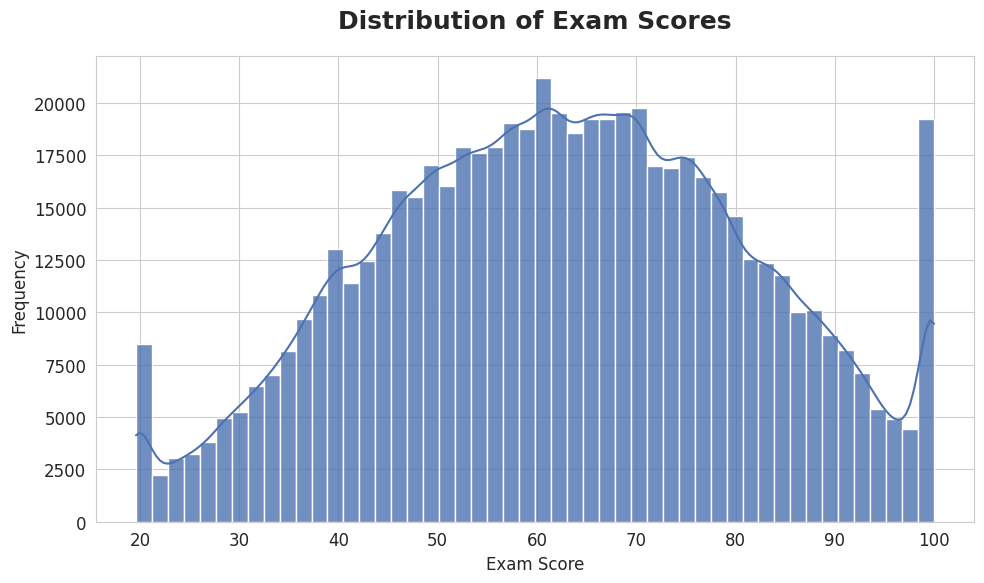

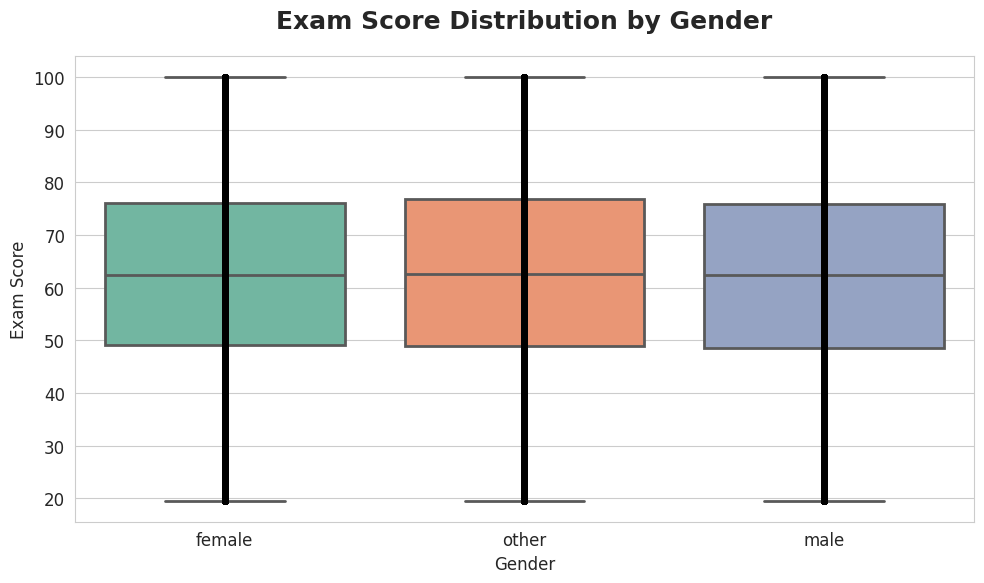

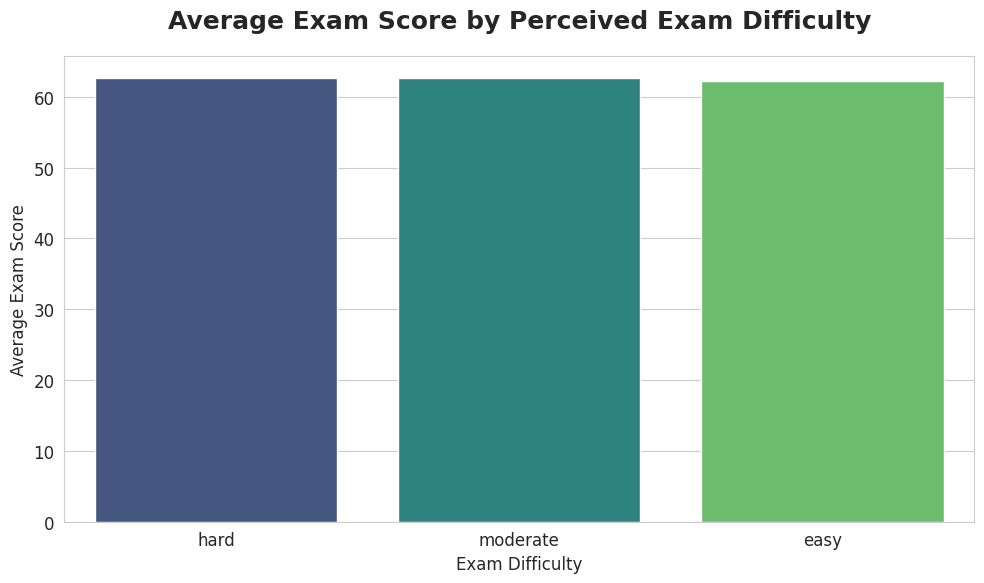

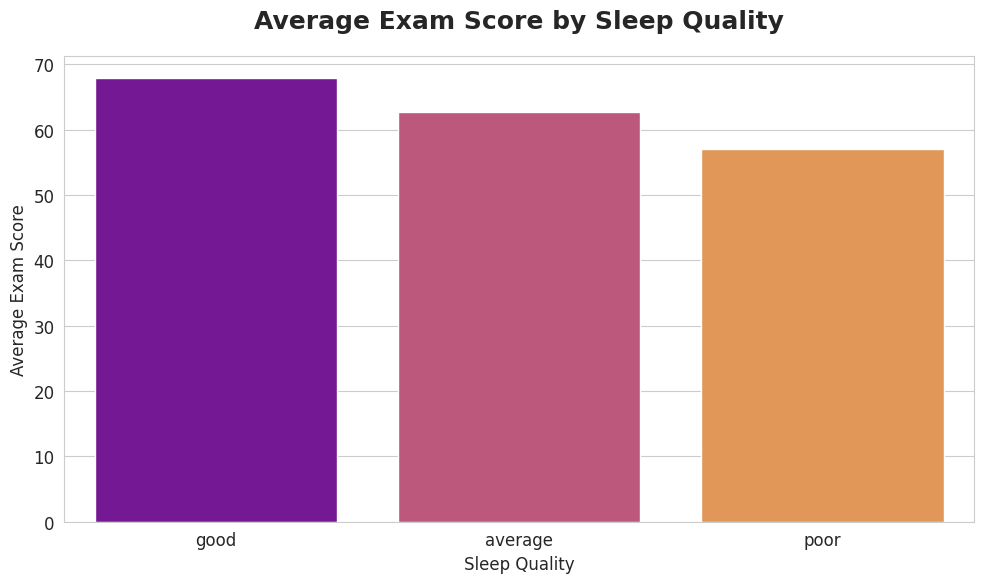

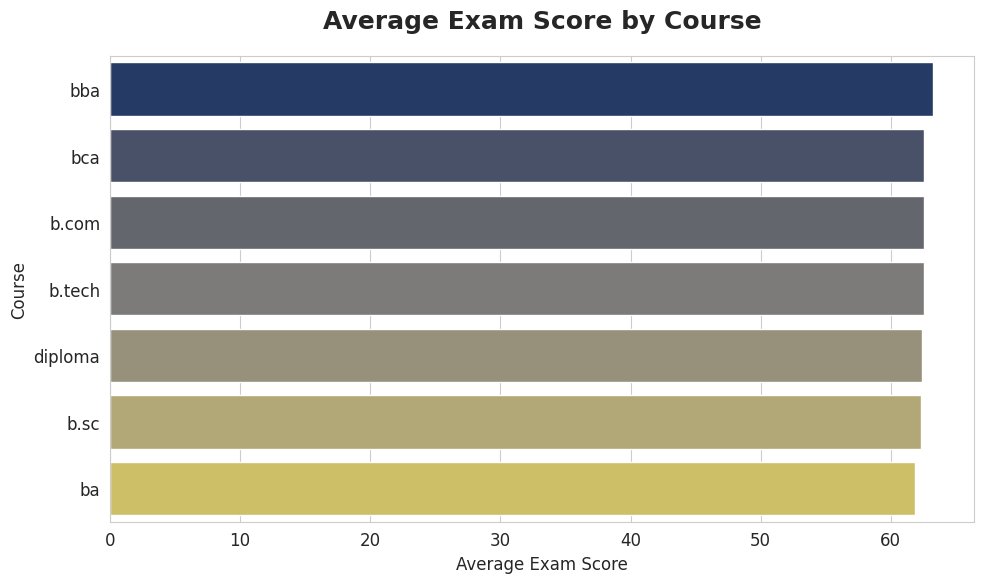

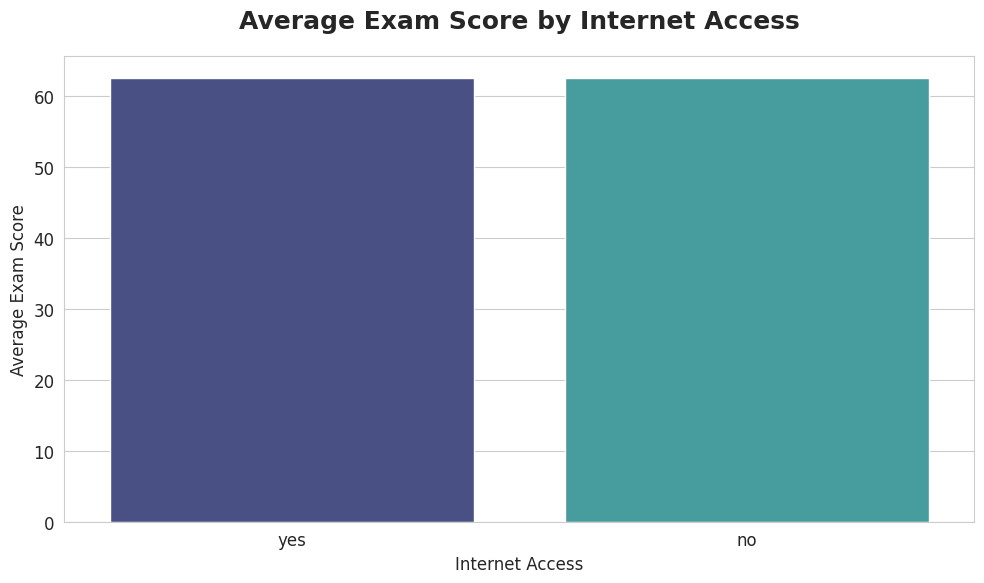

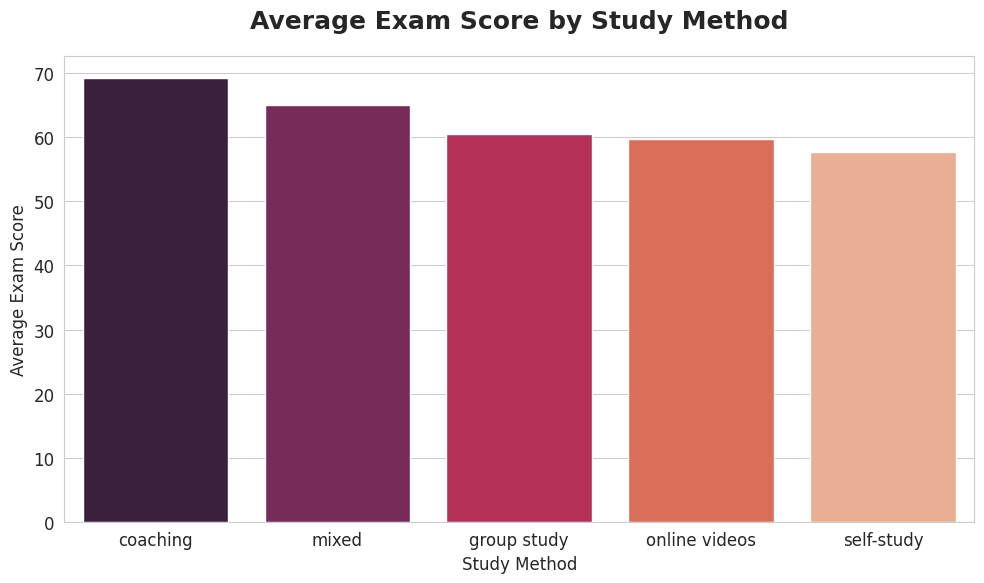

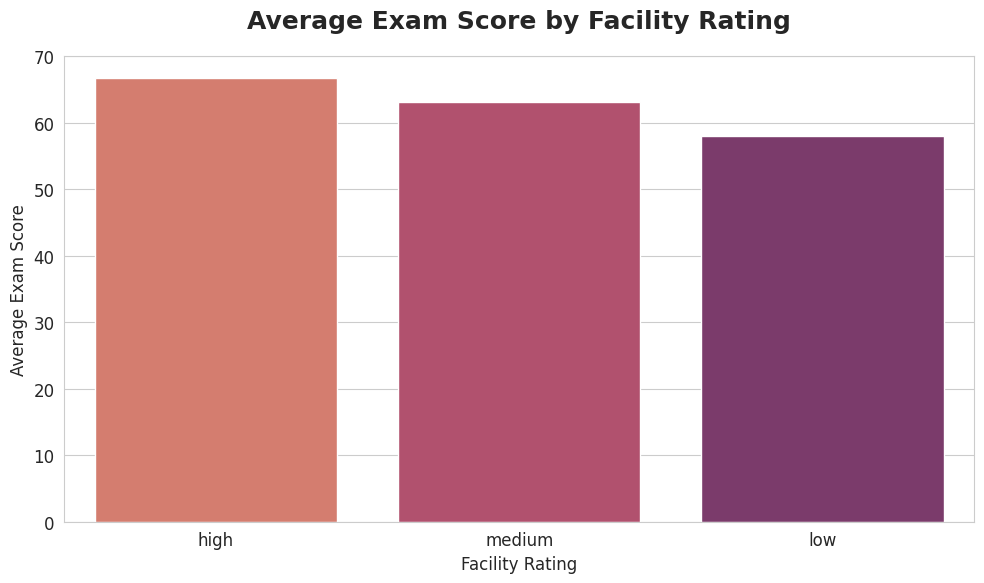

In [4]:
# Set style
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Distribution of Exam Scores
plt.figure()
sns.histplot(train['exam_score'], kde=True, bins=50, color='#4c72b0', alpha=0.8)
plt.title('Distribution of Exam Scores', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Exam Score')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Exam Score by Gender
plt.figure()
sns.boxplot(x='gender', y='exam_score', data=train, palette="Set2", linewidth=2.0)
sns.stripplot(x='gender', y='exam_score', data=train, color='black', alpha=0.2, jitter=False)
plt.title('Exam Score Distribution by Gender', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Gender')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()


# Average Exam Score by Exam Difficulty
difficulty_order = train.groupby('exam_difficulty')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(
    x='exam_difficulty', y='exam_score', data=train,
    order=difficulty_order, palette="viridis", ci=None
)
plt.title('Average Exam Score by Perceived Exam Difficulty', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Exam Difficulty')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Sleep Quality
sleep_order = train.groupby('sleep_quality')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(
    x='sleep_quality', y='exam_score', data=train,
    order=sleep_order, palette="plasma", ci=None
)
plt.title('Average Exam Score by Sleep Quality', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sleep Quality')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Course
course_order = train.groupby('course')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='exam_score', y='course', data=train, order=course_order, palette="cividis", errorbar=None)
plt.title('Average Exam Score by Course', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Average Exam Score')
plt.ylabel('Course')
plt.tight_layout()
plt.show()

# Average Exam Score by Internet Access
internet_order = train.groupby('internet_access')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='internet_access', y='exam_score', data=train, order=internet_order, palette="mako", errorbar=None)
plt.title('Average Exam Score by Internet Access', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Internet Access')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Study Method
method_order = train.groupby('study_method')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='study_method', y='exam_score', data=train, order=method_order, palette="rocket", errorbar=None)
plt.title('Average Exam Score by Study Method', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Study Method')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

# Average Exam Score by Facility Rating
facility_order = train.groupby('facility_rating')['exam_score'].mean().sort_values(ascending=False).index
plt.figure()
sns.barplot(x='facility_rating', y='exam_score', data=train, order=facility_order, palette="flare", errorbar=None)
plt.title('Average Exam Score by Facility Rating', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Facility Rating')
plt.ylabel('Average Exam Score')
plt.tight_layout()
plt.show()

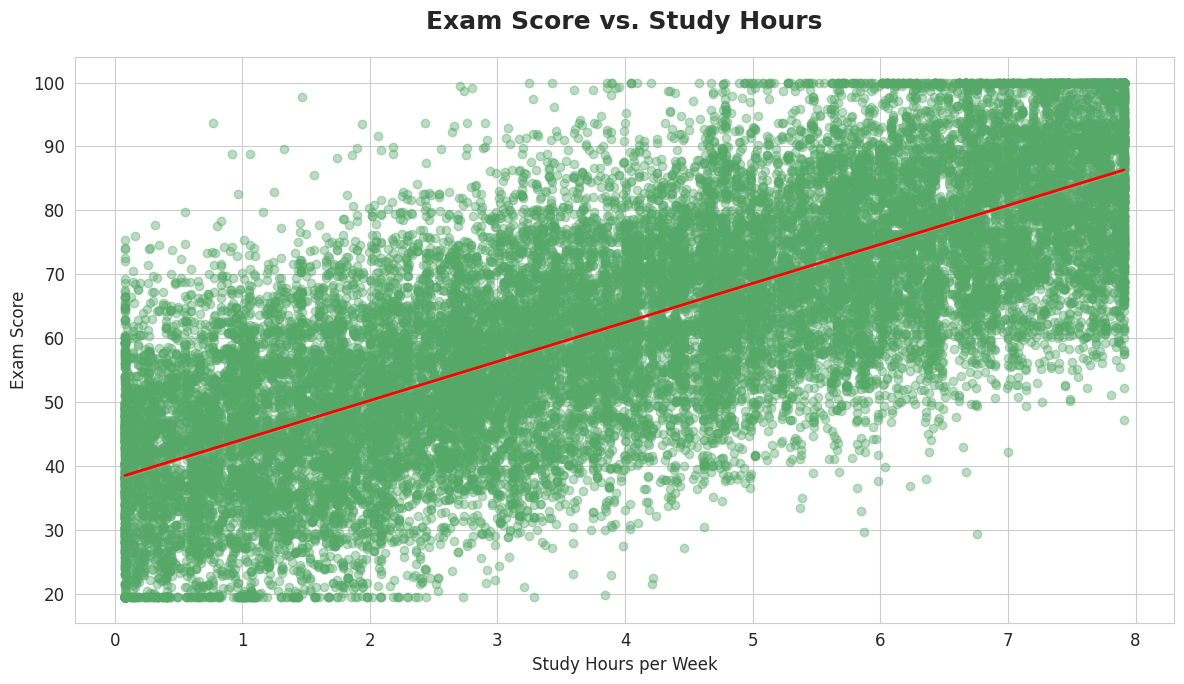

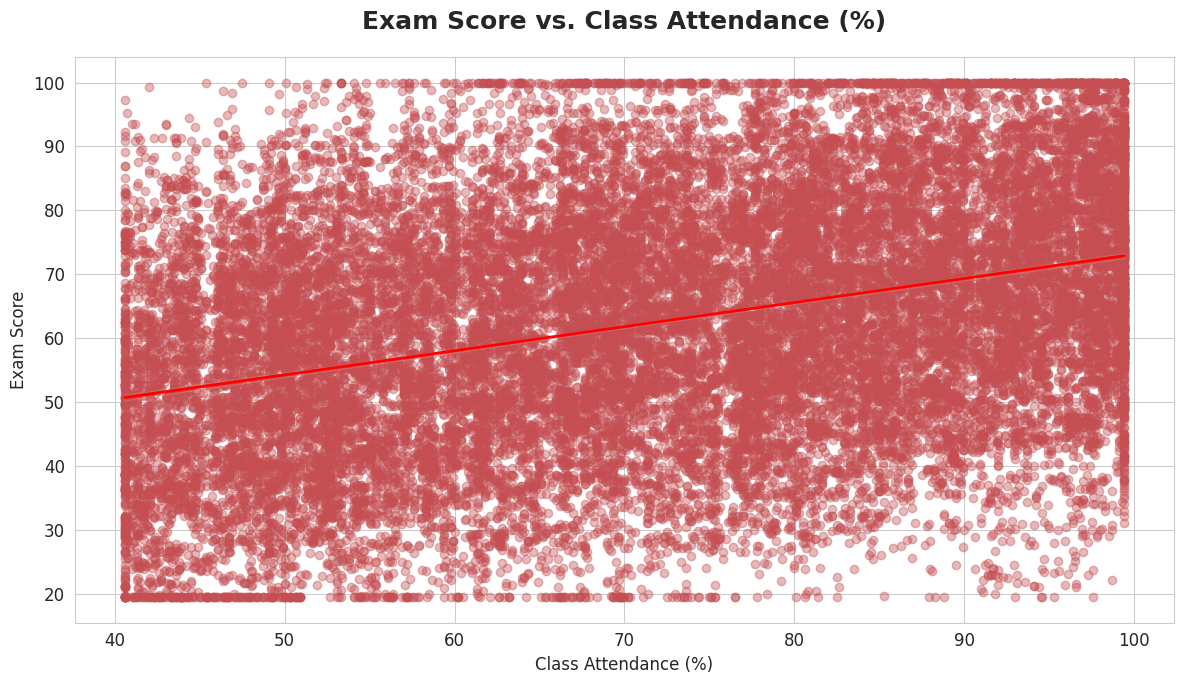

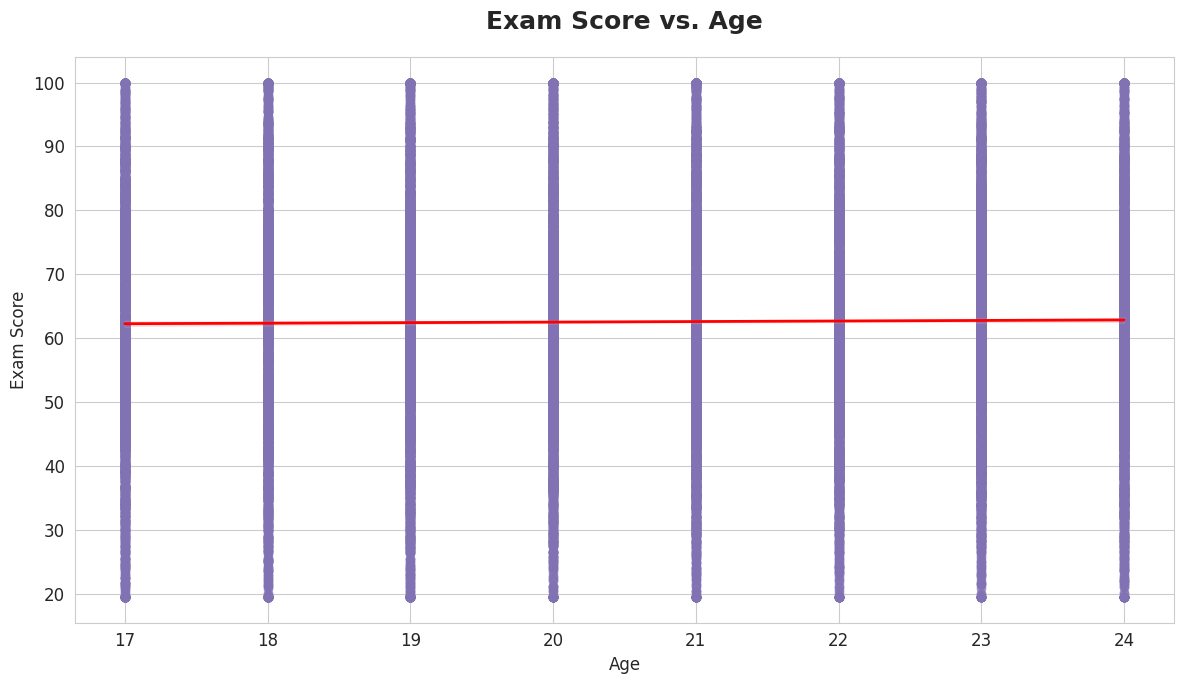

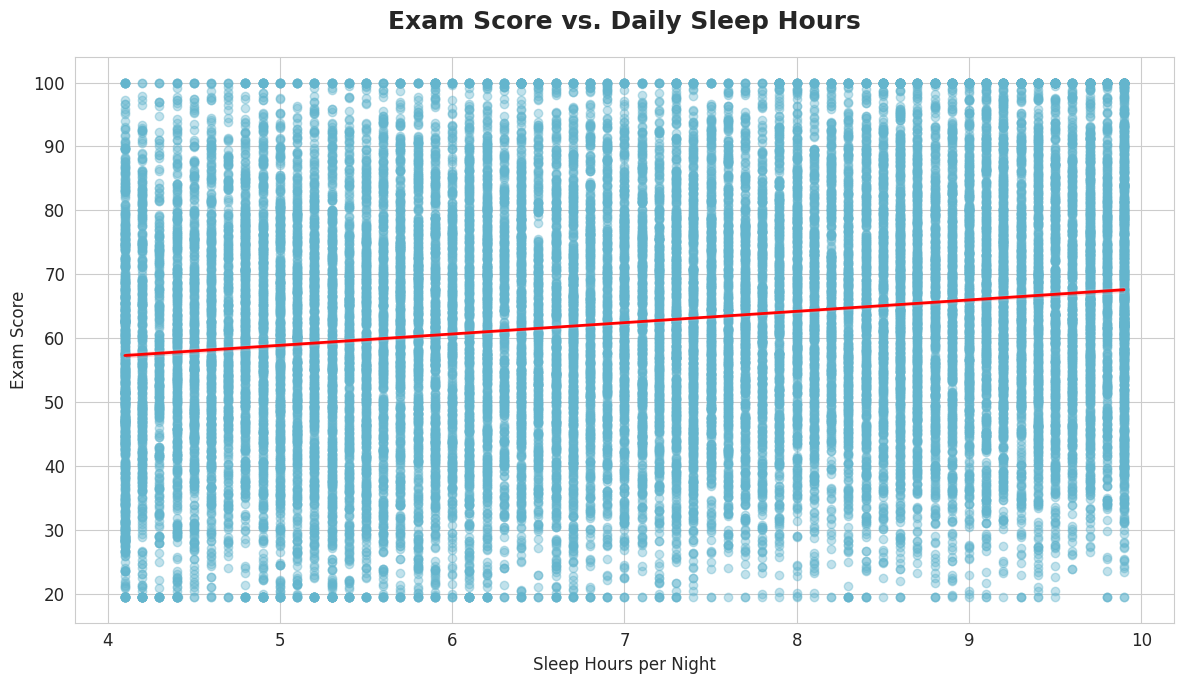

In [5]:
# Sample for faster rendering 
plot_data = train.sample(n=30000, random_state=42)

# Aesthetic settings
scatter_kws = {'alpha': 0.4, 'color': '#55a868', 'rasterized': True}
line_kws = {'color': 'red', 'linewidth': 2}

plt.rcParams['figure.figsize'] = (12, 7)

# Exam Score vs. Study Hours
plt.figure()
sns.regplot(x='study_hours', y='exam_score', data=plot_data,
            lowess=False, scatter_kws=scatter_kws, line_kws=line_kws)
plt.title('Exam Score vs. Study Hours', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Class Attendance
plt.figure()
sns.regplot(x='class_attendance', y='exam_score', data=plot_data,
            lowess=False, 
            scatter_kws={'alpha': 0.4, 'color': '#c44e52', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Class Attendance (%)', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Class Attendance (%)')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Age
plt.figure()
sns.regplot(x='age', y='exam_score', data=plot_data,
            lowess=False,
            scatter_kws={'alpha': 0.4, 'color': '#8172b3', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Age', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Age')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# Exam Score vs. Sleep Hours
plt.figure()
sns.regplot(x='sleep_hours', y='exam_score', data=plot_data,
            lowess=False,
            scatter_kws={'alpha': 0.4, 'color': '#64b5cd', 'rasterized': True},
            line_kws=line_kws)
plt.title('Exam Score vs. Daily Sleep Hours', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Sleep Hours per Night')
plt.ylabel('Exam Score')
plt.tight_layout()
plt.show()

# New Features and Preprocessing 

In [6]:
# Make copies to avoid modifying originals
train_df = train.copy()
test_df = test.copy()

# -----------------------------
# Binning nonlinear variables (same bins for train and test)
# -----------------------------

# Sleep hours binning
sleep_bins = [0, 6, 7, 8, 24]
sleep_labels = ['<6', '6-7', '7-8', '8+']

train_df['sleep_bin'] = pd.cut(
    train_df['sleep_hours'],
    bins=sleep_bins,
    labels=sleep_labels,
    include_lowest=True  #Ensures values exactly at 0 are included
)

test_df['sleep_bin'] = pd.cut(
    test_df['sleep_hours'],
    bins=sleep_bins,
    labels=sleep_labels,
    include_lowest=True
)

# Study hours binning
study_bins = [0, 5, 10, 20, 100]
study_labels = ['low', 'medium', 'high', 'very_high']

train_df['study_bin'] = pd.cut(
    train_df['study_hours'],
    bins=study_bins,
    labels=study_labels,
    include_lowest=True
)

test_df['study_bin'] = pd.cut(
    test_df['study_hours'],
    bins=study_bins,
    labels=study_labels,
    include_lowest=True
)

# -----------------------------
#Interaction feature
# -----------------------------
train_df['study_attendance_interaction'] = (
    train_df['study_hours'] * train_df['class_attendance']
)

test_df['study_attendance_interaction'] = (
    test_df['study_hours'] * test_df['class_attendance']
)

# -----------------------------
# Drop original nonlinear columns
# -----------------------------
cols_to_drop = ['sleep_hours', 'study_hours']

train_df = train_df.drop(columns=cols_to_drop)
test_df = test_df.drop(columns=cols_to_drop)

# -----------------------------
# Convert categorical columns to 'category' dtype
# -----------------------------
cat_cols = [
    'gender', 'course', 'internet_access', 'sleep_quality',
    'study_method', 'facility_rating', 'exam_difficulty',
    'sleep_bin', 'study_bin'
]

for col in cat_cols:
    # Ensure columns exist in both
    if col in train_df.columns:
        train_df[col] = train_df[col].astype('category')
    if col in test_df.columns:
        test_df[col] = test_df[col].astype('category')

#Align categories in test with train to avoid unseen categories in modeling
for col in cat_cols:
    if col in train_df.columns and col in test_df.columns:
        test_df[col] = test_df[col].cat.set_categories(train_df[col].cat.categories)


print("Feature engineering completed for both train and test sets.")
print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

Feature engineering completed for both train and test sets.
Train shape: (630000, 14)
Test shape:  (270000, 13)


# Model

In [7]:
# Prepare features and target
X = train_df.drop(columns=['exam_score', 'id'])
y = train_df['exam_score']

# Stratification key (use original train_df before dropping columns)
strat_key = train_df['course'].astype(str) + '_' + train_df['exam_difficulty'].astype(str)


# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.05,
    'num_leaves': 64,
    'min_data_in_leaf': 100,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 1,
    'verbosity': -1,
    'seed': 42
}

# Cross-validation to monitor performance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []

print("Starting Cross-Validation...")
for fold, (train_idx, val_idx) in enumerate(skf.split(X, strat_key)):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    train_set = lgb.Dataset(
        X_train, y_train,
        categorical_feature=cat_cols,
        free_raw_data=False
    )
    val_set = lgb.Dataset(
        X_val, y_val,
        categorical_feature=cat_cols,
        free_raw_data=False,
        reference=train_set
    )

    model = lgb.train(
        params,
        train_set,
        num_boost_round=2000,
        valid_sets=[train_set, val_set],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(100),
            lgb.log_evaluation(200)  #Prints every 200 rounds
        ]
    )

    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    rmse_scores.append(rmse)
    print(f"Fold {fold+1} RMSE: {rmse:.5f}")

print(f"\nCV Mean RMSE: {np.mean(rmse_scores):.5f} ± {np.std(rmse_scores):.5f}")



# ====================
# Train Final Model on Full Data
# ====================
print("\nTraining final model on full Training data...")

full_train_set = lgb.Dataset(
    X, y,
    categorical_feature=cat_cols,
    free_raw_data=False
)

final_model = lgb.train(
    params,
    full_train_set,
    num_boost_round=int(2000 * 1.1), #Slightly more rounds since no early stopping

)

print("\nDone training on full Training data!")

Starting Cross-Validation...
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 8.79439	valid's rmse: 8.85956
[400]	train's rmse: 8.73028	valid's rmse: 8.84599
[600]	train's rmse: 8.67884	valid's rmse: 8.84165
Early stopping, best iteration is:
[679]	train's rmse: 8.65993	valid's rmse: 8.84062
Fold 1 RMSE: 8.84062
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 8.79507	valid's rmse: 8.85008
[400]	train's rmse: 8.73016	valid's rmse: 8.83805
[600]	train's rmse: 8.67879	valid's rmse: 8.83524
Early stopping, best iteration is:
[662]	train's rmse: 8.66363	valid's rmse: 8.83488
Fold 2 RMSE: 8.83488
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 8.79446	valid's rmse: 8.85279
[400]	train's rmse: 8.72979	valid's rmse: 8.83857
[600]	train's rmse: 8.67879	valid's rmse: 8.83454
[800]	train's rmse: 8.63251	valid's rmse: 8.83337
Early stopping, best iteration is:
[832]	train's rmse: 8.62544	valid's rm

# Prediction and Submission

In [8]:
# ====================
#Predict on Test Set
# ====================

# Prepare test features 
X_test = test_df.drop(columns=['id'])

test_predictions = final_model.predict(X_test)


# ====================
# Create Submission File
# ====================
submission = pd.DataFrame({
    'id': test_df['id'],
    'exam_score': test_predictions
})

submission.to_csv('submission.csv', index=False)
print("\nsubmission.csv created successfully!")

submission.head()


submission.csv created successfully!


,id,exam_score
0,630000,70.486230
1,630001,71.770979
2,630002,87.596781
3,630003,54.658373
4,630004,47.321830
